## AUDIO CLASSIFICATION USING ANN

### DATESET USED :  A SUBSET OF ESC-50 

In [1]:
import librosa
audio_dataset_path=r"C:\Users\user\Downloads\ESC-50-master\ESC-50-master\audio" 
audio_file_path=r'C:\Users\user\Downloads\ESC-50-master\ESC-50-master\audio\1-137-A-32.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [2]:
print(librosa_audio_data)

[0.00656235 0.00955651 0.00642572 ... 0.00136232 0.00288864 0.00398632]


### VISUALISATION OF THE AUDIO DATA

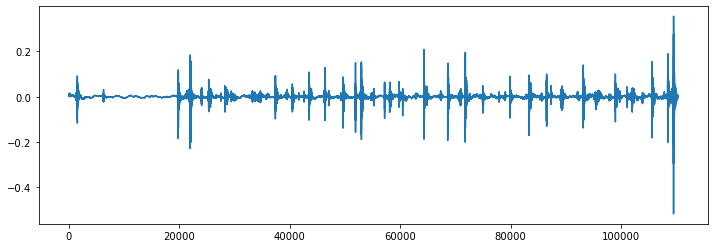

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

### DATA PREPROCESSING

In [4]:
import pandas as pd
metadata = pd.read_csv(r"C:\Users\user\Downloads\ESC-50-master\ESC-50-master\meta\esc50.csv")
metadata.drop(columns=["fold", "target", "esc10", "src_file", "take"],inplace=True)

metadata["label"]=metadata.category
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
metadata['category']=encoder.fit_transform(metadata['category'])
metadata.head()

,filename,category,label
0,1-100032-A-0.wav,18,dog
1,1-100038-A-14.wav,7,chirping_birds
2,1-100210-A-36.wav,46,vacuum_cleaner
3,1-100210-B-36.wav,46,vacuum_cleaner
4,1-101296-A-19.wav,43,thunderstorm


In [5]:
metadata=metadata[metadata['category']<=4]
metadata.head()

,filename,category,label
7,1-101404-A-34.wav,3,can_opening
25,1-11687-A-47.wav,0,airplane
51,1-17092-A-27.wav,2,brushing_teeth
52,1-17092-B-27.wav,2,brushing_teeth
53,1-17124-A-43.wav,4,car_horn


### FEATURE EXTRACTION 

In [6]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 216)


In [7]:
mfccs

array([[-415.01807  , -451.5291   , -280.0465   , ..., -129.99751  ,
         -89.79255  , -163.38759  ],
       [  84.291374 ,   93.8644   ,   25.177874 , ...,   47.161446 ,
          50.28531  ,   56.33996  ],
       [ -20.709496 ,  -20.171003 ,  -62.877335 , ...,  -39.84097  ,
         -39.935417 ,  -35.624176 ],
       ...,
       [   4.8491163,    4.1312084,    1.4178624, ...,    7.0050206,
           4.5551863,    3.8071551],
       [  13.941518 ,    9.162032 ,    5.4254246, ...,    4.1170564,
           5.1667027,    6.574893 ],
       [  -1.307696 ,   -2.006269 ,   -1.6814048, ...,   -7.505477 ,
         -10.50091  ,   -8.62315  ]], dtype=float32)

In [8]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [9]:
import numpy as np
import os
from tqdm import tqdm
extracted_features=[]
for i in range(0,200):
    file_name =os.path.join(audio_dataset_path, metadata['filename'].iloc[i])
    final_class_labels=metadata['label'].iloc[i]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

In [10]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-493.73032, 18.225063, -2.1369822, 24.183554,...",can_opening
1,"[-74.52284, 86.90861, -3.9368954, 52.791668, 6...",airplane
2,"[-303.9246, 52.03674, -41.809372, 39.32183, -6...",brushing_teeth
3,"[-538.3814, 38.297073, -16.772526, 19.91141, -...",brushing_teeth
4,"[-517.9145, 18.057663, -12.951555, 2.6231358, ...",car_horn


### SPLITTING OF DATA

In [11]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [12]:
X.shape

(200, 40)

In [13]:
### Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 40)
(40, 40)
(160, 5)
(40, 5)


### MODEL

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [17]:
num_labels=y.shape[1]

In [18]:
model=Sequential()
###first layer
model.add(Dense(300,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               12300     
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               150500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2

In [22]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 20
num_batch_size = 10


history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/20
16/16 [==============================] - 0s 11ms/step - loss: 26.9316 - accuracy: 0.3375 - val_loss: 8.3874 - val_accuracy: 0.5000
Epoch 2/20
16/16 [==============================] - 0s 3ms/step - loss: 24.3456 - accuracy: 0.3250 - val_loss: 9.7420 - val_accuracy: 0.1750
Epoch 3/20
16/16 [==============================] - 0s 3ms/step - loss: 18.5045 - accuracy: 0.3812 - val_loss: 9.9667 - val_accuracy: 0.3500
Epoch 4/20
16/16 [==============================] - 0s 3ms/step - loss: 16.5836 - accuracy: 0.4500 - val_loss: 4.1326 - val_accuracy: 0.5000
Epoch 5/20
16/16 [==============================] - 0s 3ms/step - loss: 11.3178 - accuracy: 0.4625 - val_loss: 2.9599 - val_accuracy: 0.5500
Epoch 6/20
16/16 [==============================] - 0s 3ms/step - loss: 11.5533 - accuracy: 0.5938 - val_loss: 1.9111 - val_accuracy: 0.7000
Epoch 7/20
16/16 [==============================] - 0s 3ms/step - loss: 8.7694 - accuracy: 0.5500 - val_loss: 3.8376 - val_accuracy: 0.7000
Epoch 8/20
16

In [24]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6499999761581421


In [25]:
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
train_accuracy[1]

0.7437499761581421

In [26]:
model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 2, 4, 1, 2, 1, 0, 3, 1, 1, 3, 0, 0, 3, 2, 4, 3, 4, 3, 1, 1, 3,
       0, 3, 4, 3, 1, 1, 2, 0, 4, 1, 1, 1, 3, 3, 0, 1, 2, 3], dtype=int64)

### MODEL EVALUATION

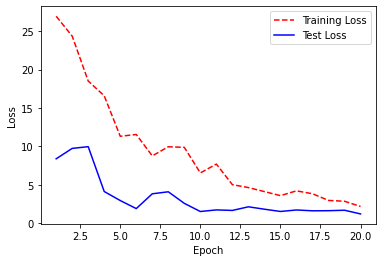

In [27]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

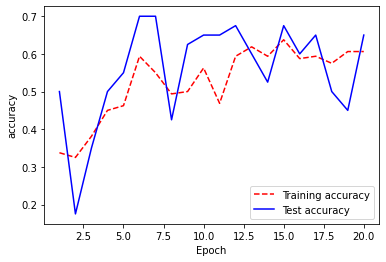

In [28]:
# Get training and test loss histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

### TESTING

In [29]:
filename=r"C:\Users\user\Downloads\ESC-50-master\ESC-50-master\audio\1-137-A-32.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-3.94703491e+02  7.34703293e+01 -3.53244591e+01  3.62132912e+01
 -9.05511665e+00  1.76549168e+01  2.65979123e+00  1.31876116e+01
 -4.06161118e+00  2.30188255e+01 -3.75202155e+00  2.06363068e+01
  1.23266423e+00  1.40234375e+01  2.04712486e+00  1.38307152e+01
 -2.92891115e-01  5.79756403e+00 -6.51220369e+00  4.31620979e+00
 -3.56035733e+00  2.31166387e+00  3.35915744e-01  2.58072639e+00
  2.86238521e-01  5.38586044e+00  2.05836892e+00  6.00837994e+00
  8.03872198e-02  1.80063653e+00  3.13867855e+00  1.23715520e+00
  1.98900068e+00 -4.56986688e-02  6.26967192e-01  1.87162018e+00
  9.04317617e-01  2.06228495e+00  1.09569526e+00  1.10982645e+00]
[[-3.94703491e+02  7.34703293e+01 -3.53244591e+01  3.62132912e+01
  -9.05511665e+00  1.76549168e+01  2.65979123e+00  1.31876116e+01
  -4.06161118e+00  2.30188255e+01 -3.75202155e+00  2.06363068e+01
   1.23266423e+00  1.40234375e+01  2.04712486e+00  1.38307152e+01
  -2.92891115e-01  5.79756403e+00 -6.51220369e+00  4.31620979e+00
  -3.56035733e+00  

array(['brushing_teeth'], dtype='<U14')